### #1

Kaggle competition: [\[link\]](https://www.kaggle.com/competitions/spaceship-titanic/)

Entry by Robin P.M. Kras

### ⭐ 1. Introduction & Overview


Welcome to the year 2912, where your data science skills are needed to solve a cosmic mystery. We've received a transmission from four lightyears away and things aren't looking good.

The Spaceship Titanic was an interstellar passenger liner launched a month ago. With almost 13,000 passengers on board, the vessel set out on its maiden voyage transporting emigrants from our solar system to three newly habitable exoplanets orbiting nearby stars.

While rounding Alpha Centauri en route to its first destination—the torrid 55 Cancri E—the unwary Spaceship Titanic collided with a spacetime anomaly hidden within a dust cloud. Sadly, it met a similar fate as its namesake from 1000 years before. Though the ship stayed intact, almost half of the passengers were transported to an alternate dimension!

### 🔹 2. Import Libraries & Set Up


In [15]:
# General
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations

# Machine Learning
import xgboost as xg
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Feature Importance & Explainability
import shap

# Settings
import warnings
warnings.filterwarnings("ignore")

# Set random seed for reproducibility
SEED = 42
np.random.seed(SEED)

print("Libraries successfully loaded. Ready to go!")

Libraries successfully loaded. Ready to go!


### 🔹 3. Load & Explore Data


In [16]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [17]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [18]:
train.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [19]:
# Quick summary of dataset
train.describe()
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


### 🔹 4. Data Visualization & EDA



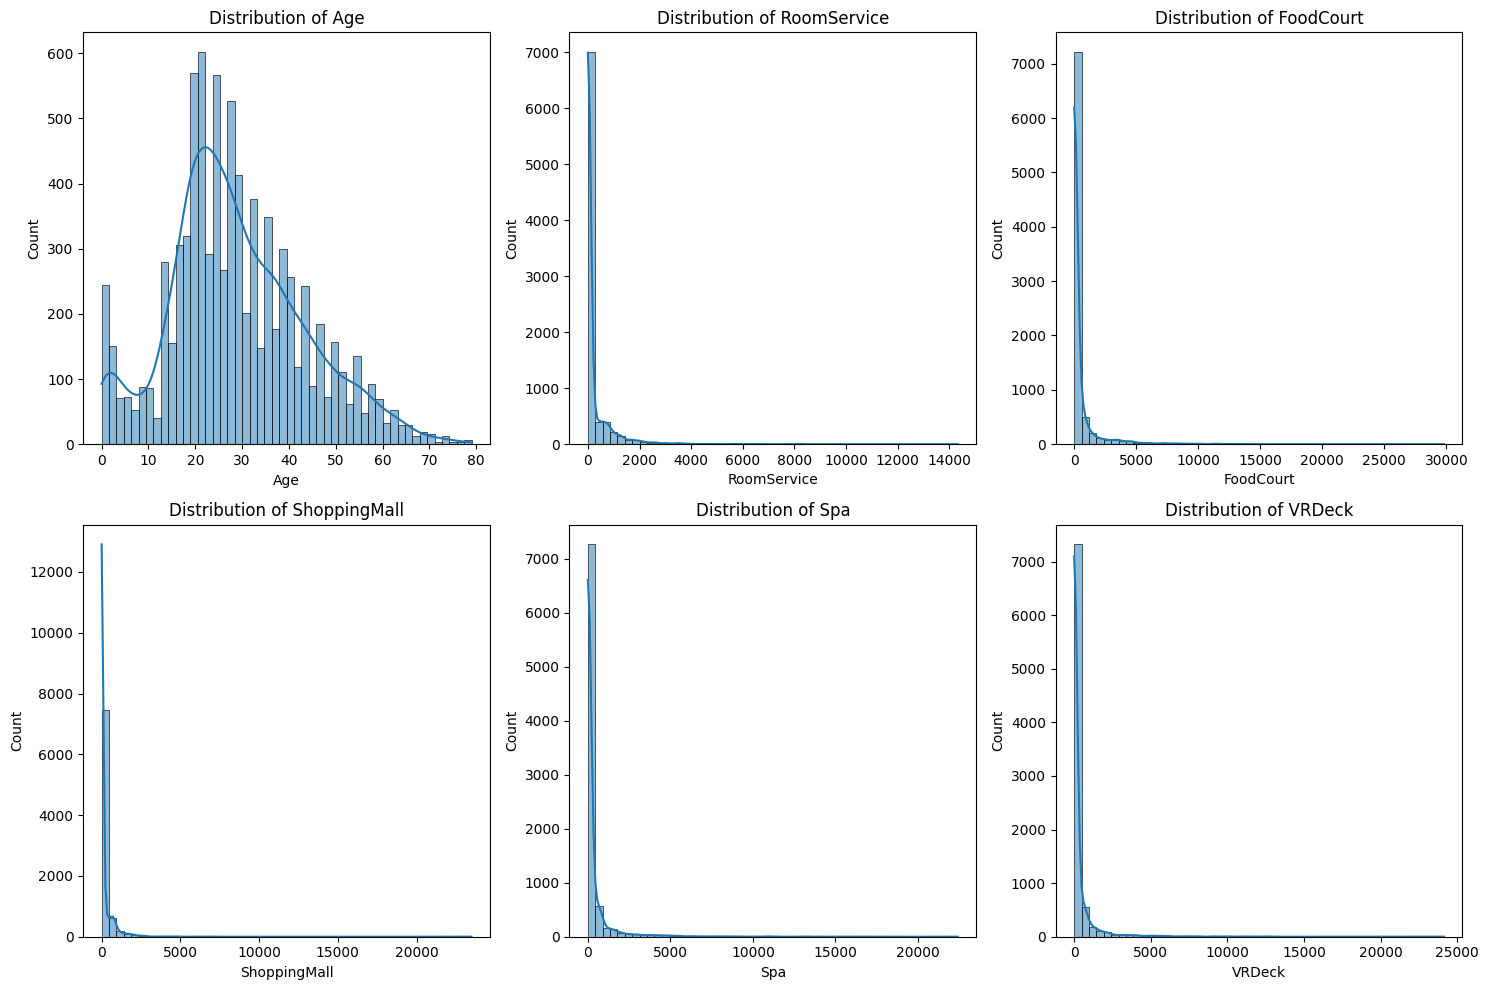

In [20]:
float_cols = [col for col in train.columns if train[col].dtype == "float64"]

cols_per_row = 3
num_plots = len(float_cols)
rows = (num_plots // cols_per_row) + (num_plots % cols_per_row > 0) 

fig, axes = plt.subplots(rows, cols_per_row, figsize=(15, 5 * rows)) 
axes = axes.flatten()  

for idx, col in enumerate(float_cols):
    sns.histplot(train[col], bins=50, kde=True, ax=axes[idx])
    axes[idx].set_title(f"Distribution of {col}")

for i in range(idx + 1, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

Regardless of age, most distributions are heavily skewed towards one side.

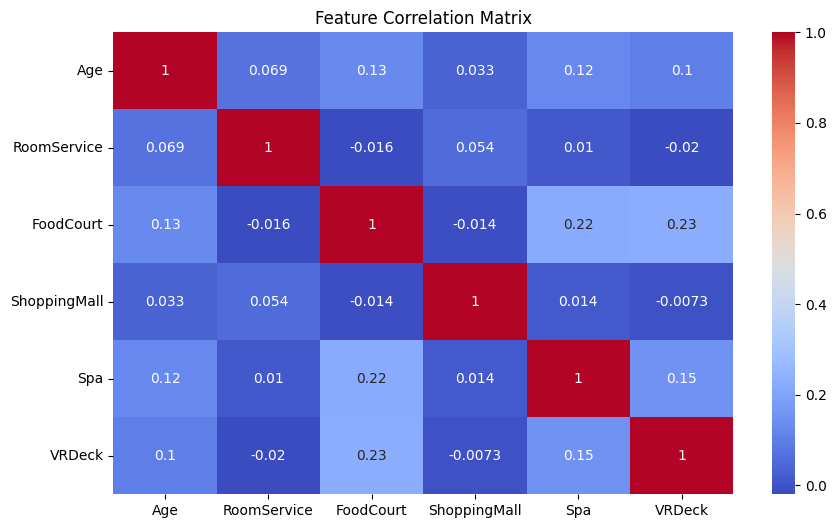

In [21]:
heatmap_train = pd.DataFrame()

for col in train.columns:
    if train[col].dtype == "float64":
        heatmap_train[col] = train[col]

plt.figure(figsize=(10,6))
sns.heatmap(heatmap_train.corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation Matrix")
plt.show()

The heatmap shows that out of all of the features, all that obtain a score of over >0.2 are at least somewhat tied together and related. This means that FoodCourt, Spa, and VRDeck will be important later.

### 🔹 5. Feature Engineering

In [22]:
train.columns = train.columns.str.strip()
test.columns = test.columns.str.strip()

In [23]:
print(f"Train set, null count: \n{train.isnull().sum()}")
print("\n")
print(f"Test set, null count: \n{test.isnull().sum()}")

Train set, null count: 
PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64


Test set, null count: 
PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64


We replace missing categorical values using the mode and missing numeric values with the mean.

In [24]:
for col in train.columns:
    if train[col].dtype == "object":
        train[col] = train[col].fillna(train[col].mode()[0])
    elif train[col].dtype == "float64":
        train[col] = train[col].fillna(train[col].mean())

for col in test.columns:
    if test[col].dtype == "object":
        test[col] = test[col].fillna(test[col].mode()[0])
    elif test[col].dtype == "float64":
        test[col] = test[col].fillna(test[col].mean())    

In [25]:
print(f"Train set, null count: \n{train.isnull().sum()}")
print("\n")
print(f"Test set, null count: \n{test.isnull().sum()}")

Train set, null count: 
PassengerId     0
HomePlanet      0
CryoSleep       0
Cabin           0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Name            0
Transported     0
dtype: int64


Test set, null count: 
PassengerId     0
HomePlanet      0
CryoSleep       0
Cabin           0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Name            0
dtype: int64


In [ ]:
import itertools

features = ['Age', 'ShoppingMall', 'Spa', 'VRDeck']

def create_combination_features(df, features):
    combinations = itertools.combinations(features, 2)
    
    for comb in combinations:
        feature_name = '_'.join(comb) 
        df[feature_name] = df[list(comb)].mean(axis=1)
    
    return df

train = create_combination_features(train, features)
test = create_combination_features(test, features)

In [27]:
test.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Age_ShoppingMall,Age_Spa,Age_VRDeck,ShoppingMall_Spa,ShoppingMall_VRDeck,Spa_VRDeck
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning,13.5,13.5,13.5,0.0,0.0,0.0
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers,9.5,1421.0,9.5,1411.5,0.0,1411.5
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus,15.5,15.5,15.5,0.0,0.0,0.0
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter,19.0,109.5,311.5,90.5,292.5,383.0
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez,327.5,10.0,10.0,317.5,317.5,0.0


### 🔹 6. Model Selection

We will try using XGBoost Classification for this problem.

In [28]:
X = train.drop(columns=["PassengerId", "Transported", "HomePlanet", "Cabin", "Destination", "Name"])
X_test = test.drop(columns=["PassengerId", "HomePlanet", "Cabin", "Destination", "Name"])

y = train["Transported"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=SEED)

model = xg.XGBClassifier()
model.fit(X_train, y_train)
predictions = model.predict(X_test)

output = pd.DataFrame({'PassengerId': test.PassengerId, 'Transported': predictions})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


### 🔹 7. Model Evaluation

In [29]:
val_predictions = model.predict(X_val)

accuracy = accuracy_score(val_predictions, y_val)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 77.52%


### 🔹 8. Retry: Model Selection

In [30]:
X = train.drop(columns=["PassengerId", "Transported", "HomePlanet", "Cabin", "Destination", "Name"])
X_test = test.drop(columns=["PassengerId", "HomePlanet", "Cabin", "Destination", "Name"])

y = train["Transported"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=SEED)

model = RandomForestClassifier()
model.fit(X_train, y_train)
predictions = model.predict(X_test)

output = pd.DataFrame({'PassengerId': test.PassengerId, 'Transported': predictions})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


In [31]:
val_predictions = model.predict(X_val)

accuracy = accuracy_score(val_predictions, y_val)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 76.31%


### 🔹 9. Retry: XGBoost with GridSearchCV

In [32]:
param_grid = {
    'n_estimators': [100, 200, 300],  
    'learning_rate': [0.01, 0.05, 0.1],  
    'max_depth': [3, 5, 7],  
    'subsample': [0.8, 0.9, 1.0], 
    'colsample_bytree': [0.8, 0.9, 1.0]
}

grid_search = GridSearchCV(xg.XGBClassifier(random_state=SEED), param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)

best_params = grid_search.best_params_

Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200, 'subsample': 1.0}


In [33]:
X = train.drop(columns=["PassengerId", "Transported", "HomePlanet", "Cabin", "Destination", "Name"])
X_test = test.drop(columns=["PassengerId", "HomePlanet", "Cabin", "Destination", "Name"])

y = train["Transported"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=SEED)

model = xg.XGBClassifier(**best_params)
model.fit(X_train, y_train)
predictions = model.predict(X_test)

predictions = predictions.astype(bool)

output = pd.DataFrame({'PassengerId': test['PassengerId'], 'Transported': predictions})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


In [34]:
val_predictions = model.predict(X_val)

accuracy = accuracy_score(val_predictions, y_val)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 78.21%


The performance has improved somewhat! And so has my ranking :-)

### 🔹 Experiment

In [35]:
y = train["Transported"]

features=["Age", "HomePlanet", "Destination", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]

X = pd.get_dummies(train[features])
X_test = pd.get_dummies(test[features])

model = xg.XGBClassifier(**best_params)
model.fit(X, y)
predictions = model.predict(X_test)

predictions = predictions.astype(bool)

output = pd.DataFrame({'PassengerId': test['PassengerId'], 'Transported': predictions})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


Using only these features has increased my performance marginally!